In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### load dataframe
get the dataframe with all syllabi and the dataframe with courses

In [2]:
# Custom parsing considering the semicolon as a delimiter and potential multiline records
syllabi_df = pd.read_csv("syllabi.csv", delimiter=';')
course_df = pd.read_excel('tekems_section_demand_20230124_1930.xlsx')

# Display the first few records to verify if the dataframe is loaded correctly
syllabi_df.head()
course_df.head()

,lective,section_term,course,course_name,section,last_section_update,max_section_students,section_vacancies,demand_bidding_s1_g1_primary_list,demand_bidding_s1_g2_primary_list,...,allocations_bidding_s2_g1_alternative_list,allocations_bidding_s2_g2_alternative_list,allocations_wailist_t1,allocations_wailist_t2,allocations_wailist_t3,allocations_wailist_t4,cancellations_wailist_t1,cancellations_wailist_t2,cancellations_wailist_t3,cancellations_wailist_t4
0,201718,S1,2253,Corporate Finance,TA,2018-03-27 15:32:24,80,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,201718,S1,2174,Macroeconomic Analysis,TA,2018-01-15 08:42:43,70,8,0,0,...,0,0,0,0,0,0,0,0,0,0
2,201718,S1,2206,Banking,TA,2017-10-30 16:44:25,70,3,26,45,...,0,0,8,0,0,0,9,0,0,0
3,201718,S1,2827,Negotiation Strategy,TA,2017-09-12 17:44:06,48,3,54,0,...,0,0,3,0,0,0,5,0,0,0
4,201718,S1,2578,Mastering Your Career,TA,2018-01-15 08:54:29,650,48,0,0,...,0,0,0,0,0,0,0,0,0,0


### merge the dataframes
find the correct syllabi for each course by looking through the filenames and match them with the course code. merge the two dataframes. 

In [3]:
def find_matching_course_code(name_text, course_codes):
    """
    Find a course code within the 'name' text that matches any code in the 'course_codes' set.
    """
    if not isinstance(name_text, str):
        return None  # Return None if text is not a string (it could be NaN or None)

    # Extract all numeric sequences from the name text
    found_codes = re.findall(r'\d+', name_text)
    
    # Check if any of the found codes match the known course codes
    for code in found_codes:
        if int(code) in course_codes:
            return int(code)  # Return the matching course code
    
    return None  # If no match is found

# Creating a set of all course codes for faster lookup
course_codes_set = set(course_df['course'])

# Finding matching course codes within the 'name' column of 'syllabi_df'
syllabi_df['matched_course_code'] = syllabi_df['name'].apply(lambda name: find_matching_course_code(name, course_codes_set))

# Filtering out rows where no matching course code was found
syllabi_with_codes_df = syllabi_df[syllabi_df['matched_course_code'].notna()]

# Merging the dataframes based on the matched course codes
merged_df_specific_code = pd.merge(course_df, syllabi_with_codes_df, left_on='course', right_on='matched_course_code', how='left')

# Checking the first few rows of the merged dataframe to ensure the merge was successful
merged_df_specific_code.head()


,lective,section_term,course,course_name,section,last_section_update,max_section_students,section_vacancies,demand_bidding_s1_g1_primary_list,demand_bidding_s1_g2_primary_list,...,allocations_wailist_t2,allocations_wailist_t3,allocations_wailist_t4,cancellations_wailist_t1,cancellations_wailist_t2,cancellations_wailist_t3,cancellations_wailist_t4,name,syllabus,matched_course_code
0,201718,S1,2253,Corporate Finance,TA,2018-03-27 15:32:24,80,3,0,0,...,0,0,0,0,0,0,0,202223_2253_publica.pdf,"COURSE SYLLABUS\n2253 - Corporate Finance, 7 E...",2253.0
1,201718,S1,2253,Corporate Finance,TA,2018-03-27 15:32:24,80,3,0,0,...,0,0,0,0,0,0,0,202122_2253_S1.pdf,"COURSE SYLLABUS\n2253 - Corporate Finance, 7 E...",2253.0
2,201718,S1,2253,Corporate Finance,TA,2018-03-27 15:32:24,80,3,0,0,...,0,0,0,0,0,0,0,202021_2253.pdf,"COURSE SYLLABUS\n2253 - Corporate Finance, 7 E...",2253.0
3,201718,S1,2253,Corporate Finance,TA,2018-03-27 15:32:24,80,3,0,0,...,0,0,0,0,0,0,0,2253 - Syllabus CP Fall 2019 Jul042019.pdf,\n1 \n \n2253 – Corporate Finance (Anjos/Dem...,2253.0
4,201718,S1,2174,Macroeconomic Analysis,TA,2018-01-15 08:42:43,70,8,0,0,...,0,0,0,0,0,0,0,202223_2174_publica.pdf,COURSE SYLLABUS\n2174 - Macroeconomic Analysis...,2174.0


In [4]:
# Focus on relevant columns
merged_df_specific_code = merged_df_specific_code[["lective", "section_term", "course", "course_name", "name", "syllabus", "matched_course_code"]]
merged_df_specific_code

,lective,section_term,course,course_name,name,syllabus,matched_course_code
0,201718,S1,2253,Corporate Finance,202223_2253_publica.pdf,"COURSE SYLLABUS\n2253 - Corporate Finance, 7 E...",2253.0
1,201718,S1,2253,Corporate Finance,202122_2253_S1.pdf,"COURSE SYLLABUS\n2253 - Corporate Finance, 7 E...",2253.0
2,201718,S1,2253,Corporate Finance,202021_2253.pdf,"COURSE SYLLABUS\n2253 - Corporate Finance, 7 E...",2253.0
3,201718,S1,2253,Corporate Finance,2253 - Syllabus CP Fall 2019 Jul042019.pdf,\n1 \n \n2253 – Corporate Finance (Anjos/Dem...,2253.0
4,201718,S1,2174,Macroeconomic Analysis,202223_2174_publica.pdf,COURSE SYLLABUS\n2174 - Macroeconomic Analysis...,2174.0
...,...,...,...,...,...,...,...
13292,202223,T4,2204,"Mergers, Acquisitions, Restructuring","2204– Mergers, Acquisitions, Restructuring_TA_...","\nMASTERS SYLLABUS \n2204– Mergers, Acquisi...",2204.0
13293,202223,T4,2204,"Mergers, Acquisitions, Restructuring","2204 - Mergers, Acquisitions and Restructuring...","\nMASTERS SYLLABUS \n2204 – Mergers, Acquis...",2204.0
13294,202223,T4,2204,"Mergers, Acquisitions, Restructuring","2204 - Mergers, Acquisitions and Restructuring...","\n \nMASTERS SYLLABUS \n2204– Mergers, Acqu...",2204.0
13295,202223,T4,2204,"Mergers, Acquisitions, Restructuring","2204 - Mergers, Acquisitions, Restructuring_T3...","\n \nMASTERS SYLLABUS \n2204– Mergers, Acqui...",2204.0


### find number of clusters
Use the Elbow method to find the right amount of clusters. In this case it would be 4-5 clusters.

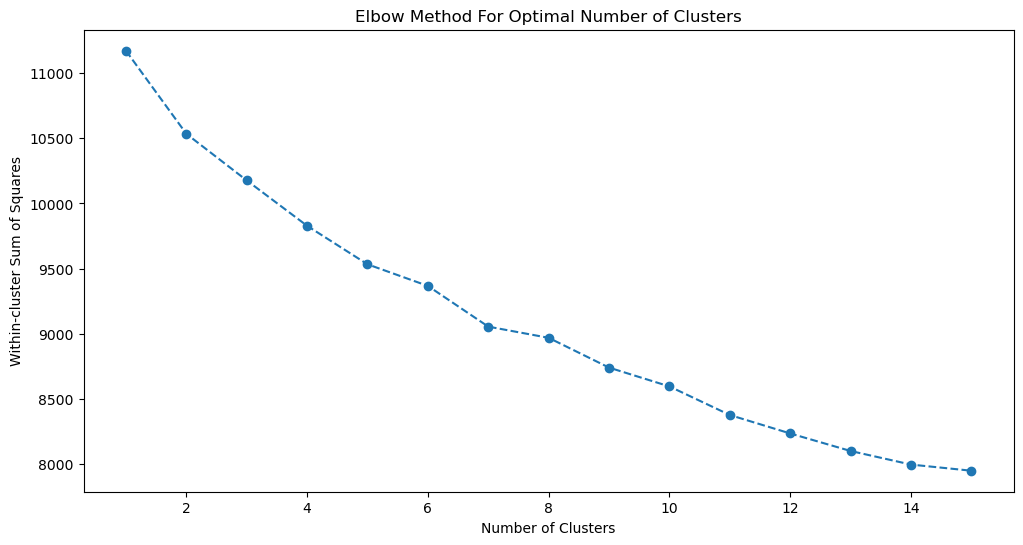

In [6]:
# Text preprocessing and cleaning
# For the sake of processing time, we'll use basic cleaning: removing numerical values, common stop words, and lowercasing the text

# Function to clean text
def clean_text(text):
    # If the text is not a string, return an empty string
    if not isinstance(text, str):
        return ''
    
    # Basic cleaning
    text = text.lower()  # lowercase text
    text = ''.join([word for word in text if not word.isdigit()])  # remove digits
    text = ' '.join(word for word in text.split() if word.isalpha())  # remove non-alphabetic characters
   
    return text

# Cleaning the syllabus text
merged_df_specific_code['cleaned_syllabus'] = merged_df_specific_code['syllabus'].apply(clean_text)

# Initialize a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Limiting to 1000 features for efficiency

# Transform the cleaned syllabus text into a TF-IDF matrix
X = vectorizer.fit_transform(merged_df_specific_code['cleaned_syllabus'])

# Calculating error for a range of number of clusters (from 1 to 15)
wcss = []  # Within-cluster sum of squares
for i in range(1, 16):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Sum of squared distances of samples to their closest cluster center

# Plotting the elbow curve
plt.figure(figsize=(12, 6))
plt.plot(range(1, 16), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.show()


### clustering
Use kmeans to form 5 clusters.

In [7]:
# Using KMeans clustering to cluster the syllabus data
# We're starting with an assumption of 5 clusters (this can be adjusted)
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)

# Adding cluster information back to the original dataframe
merged_df_specific_code['cluster'] = kmeans.labels_

# Showing the first few rows of the dataframe after clustering
merged_df_specific_code.head()


c:\Users\celin\anaconda3\envs\DataSquad\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,lective,section_term,course,course_name,name,syllabus,matched_course_code,cleaned_syllabus,cluster
0,201718,S1,2253,Corporate Finance,202223_2253_publica.pdf,"COURSE SYLLABUS\n2253 - Corporate Finance, 7 E...",2253.0,course syllabus corporate ects fall semester n...,2
1,201718,S1,2253,Corporate Finance,202122_2253_S1.pdf,"COURSE SYLLABUS\n2253 - Corporate Finance, 7 E...",2253.0,course syllabus corporate ects fall semester n...,2
2,201718,S1,2253,Corporate Finance,202021_2253.pdf,"COURSE SYLLABUS\n2253 - Corporate Finance, 7 E...",2253.0,course syllabus corporate ects fall semester n...,2
3,201718,S1,2253,Corporate Finance,2253 - Syllabus CP Fall 2019 Jul042019.pdf,\n1 \n \n2253 – Corporate Finance (Anjos/Dem...,2253.0,corporate finance masters co urse syllabus fal...,2
4,201718,S1,2174,Macroeconomic Analysis,202223_2174_publica.pdf,COURSE SYLLABUS\n2174 - Macroeconomic Analysis...,2174.0,course syllabus macroeconomic ects fall semest...,4


### cluster description
See the 10 most important words for each cluster, to get a better impression on the clusters.

In [8]:
# Getting the terms (words) from the TF-IDF vectorizer
terms = vectorizer.get_feature_names_out()

# Creating a dictionary to hold the top terms for each cluster
top_terms_per_cluster = {}

# Number of top terms to identify for each cluster
num_top_terms = 10

# Extracting the centroids of the clusters
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# Identifying the top terms for each cluster
for i in range(kmeans.n_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :num_top_terms]]
    top_terms_per_cluster[i] = top_terms

top_terms_per_cluster  # Displaying the top terms for each cluster to understand their themes


{0: ['statistics',
  'statistical',
  'ff',
  'analysis',
  'course',
  'need',
  'variable',
  'students',
  'research',
  'engineering'],
 1: ['marketing',
  'brand',
  'course',
  'digital',
  'communications',
  'syllabus',
  'group',
  'students',
  'plan',
  'develop'],
 2: ['financial',
  'course',
  'syllabus',
  'finance',
  'investment',
  'accounting',
  'valuation',
  'risk',
  'students',
  'capital'],
 3: ['human',
  'hrm',
  'hr',
  'managers',
  'consumer',
  'research',
  'management',
  'behavioral',
  'course',
  'group'],
 4: ['course',
  'business',
  'students',
  'syllabus',
  'data',
  'class',
  'international',
  'strategy',
  'nova',
  'learning']}

In [9]:
cluster0 = merged_df_specific_code.loc[merged_df_specific_code['cluster'] == 0]
cluster0 = cluster0["course_name"].unique()
print(cluster0)

cluster1 = merged_df_specific_code.loc[merged_df_specific_code['cluster'] == 1]
cluster1 = cluster1["course_name"].unique()
print(cluster1)

cluster2 = merged_df_specific_code.loc[merged_df_specific_code['cluster'] == 2]
cluster2 = cluster2["course_name"].unique()
print(cluster2)

cluster3 = merged_df_specific_code.loc[merged_df_specific_code['cluster'] == 3]
cluster3 = cluster3["course_name"].unique()
print(cluster3)

cluster4 = merged_df_specific_code.loc[merged_df_specific_code['cluster'] == 4]
cluster4 = cluster4["course_name"].unique()
print(cluster4)

['Statistics I' 'Statistics III' 'Statistics II'
 'Statistics for Policy Action']
['Brand Management' 'Advanced Marketing' 'Marketing Management'
 'Marketing Research' 'Special Project L´Oreal Brandstorm'
 'Integrated Marketing Communications' 'International Marketing Strategy'
 'Digital Marketing' 'Methods for Applied Business Problems'
 'Marketing Analytics' 'Cross-Cultural Issues for Marketing'
 'Not for Profit and Social Marketing'
 'Marketing Channels in The Digital Age'
 'Special Course L´Oreal Brandstorm Competition'
 'Brand Management for Hospitality' 'Asian Brands' 'Social Marketing'
 'Tourism Marketing' 'Advanced Branding and Brand Development'
 'Principles of Shopper Marketing'
 'Brands and Marketing in Asia´s Emerging Markets'
 'Better Marketing for Consumer Wellbeing']
['Corporate Finance' 'Banking' 'Financial Management' 'Investments'
 'Nova Students Portfolio' 'Econometrics' 'Applied Corporate Finance'
 'Futures and Options' 'Financial Reporting'
 'Seminar on Current Eco

In [16]:
merged_df_specific_code.to_csv("coursesyllabi.csv", sep = ";", index=False)

Merge the cluster number with the courses to identify the demand per cluster.

In [28]:
#assign cluster number to course
all_courses_df = pd.merge(course_df, merged_df_specific_code[["course", "cluster"]].drop_duplicates(subset=['course']), on='course', how='left')
all_courses_df.head()

,lective,section_term,course,course_name,section,last_section_update,max_section_students,section_vacancies,demand_bidding_s1_g1_primary_list,demand_bidding_s1_g2_primary_list,...,allocations_bidding_s2_g2_alternative_list,allocations_wailist_t1,allocations_wailist_t2,allocations_wailist_t3,allocations_wailist_t4,cancellations_wailist_t1,cancellations_wailist_t2,cancellations_wailist_t3,cancellations_wailist_t4,cluster
0,201718,S1,2253,Corporate Finance,TA,2018-03-27 15:32:24,80,3,0,0,...,0,0,0,0,0,0,0,0,0,2
1,201718,S1,2174,Macroeconomic Analysis,TA,2018-01-15 08:42:43,70,8,0,0,...,0,0,0,0,0,0,0,0,0,4
2,201718,S1,2206,Banking,TA,2017-10-30 16:44:25,70,3,26,45,...,0,8,0,0,0,9,0,0,0,2
3,201718,S1,2827,Negotiation Strategy,TA,2017-09-12 17:44:06,48,3,54,0,...,0,3,0,0,0,5,0,0,0,4
4,201718,S1,2578,Mastering Your Career,TA,2018-01-15 08:54:29,650,48,0,0,...,0,0,0,0,0,0,0,0,0,4
